# Model Selection for Regression

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
housing = pd.read_csv("https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.dropna(subset = ['total_bedrooms'], inplace=True)

In [4]:
y = housing['median_house_value']
X = housing.drop(columns=['median_house_value'])

Create a random feature to see how to detect not important features

In [5]:
X['random'] = (np.random.rand(len(housing))>0.5).astype(int)

### Split data into Train and Test

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Create transformer for the nominal data

In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [8]:
transform = ColumnTransformer([('OneHot', OneHotEncoder(drop='first'), ['ocean_proximity'])], remainder='passthrough')
transform.fit(X_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


ColumnTransformer(remainder='passthrough',
                  transformers=[('OneHot', OneHotEncoder(drop='first'),
                                 ['ocean_proximity'])])

After transformer our data looks as follows

In [9]:
X_train_hot = pd.DataFrame(transform.transform(X_train), columns=transform.get_feature_names_out())
X_train_hot.head()

,OneHot__ocean_proximity_INLAND,OneHot__ocean_proximity_ISLAND,OneHot__ocean_proximity_NEAR BAY,OneHot__ocean_proximity_NEAR OCEAN,remainder__longitude,remainder__latitude,remainder__housing_median_age,remainder__total_rooms,remainder__total_bedrooms,remainder__population,remainder__households,remainder__median_income,remainder__random
0,0.0,0.0,0.0,0.0,-121.80,37.32,14.0,4412.0,924.0,2698.0,891.0,4.7027,0.0
1,1.0,0.0,0.0,0.0,-119.63,36.64,33.0,1036.0,181.0,620.0,174.0,3.4107,0.0
2,1.0,0.0,0.0,0.0,-118.06,34.12,25.0,3891.0,848.0,1848.0,759.0,3.6639,1.0
3,0.0,0.0,0.0,0.0,-118.31,34.07,28.0,2362.0,949.0,2759.0,894.0,2.2364,1.0
4,0.0,0.0,0.0,1.0,-117.27,33.04,27.0,1839.0,392.0,1302.0,404.0,3.5500,0.0


In [11]:
X_test_hot = pd.DataFrame(transform.transform(X_test), columns=transform.get_feature_names_out())

## Choosing Data by Correlation, Mutual Information, and by Model

$$
\operatorname{Cor}(X;Y) = \frac{(X-\bar{X})^T (Y-\bar{Y})}{\sqrt{\operatorname{Var}[X]}\sqrt{\operatorname{Var}[Y]}}
$$

Add target variable to the data to see the correlation

<Axes: >

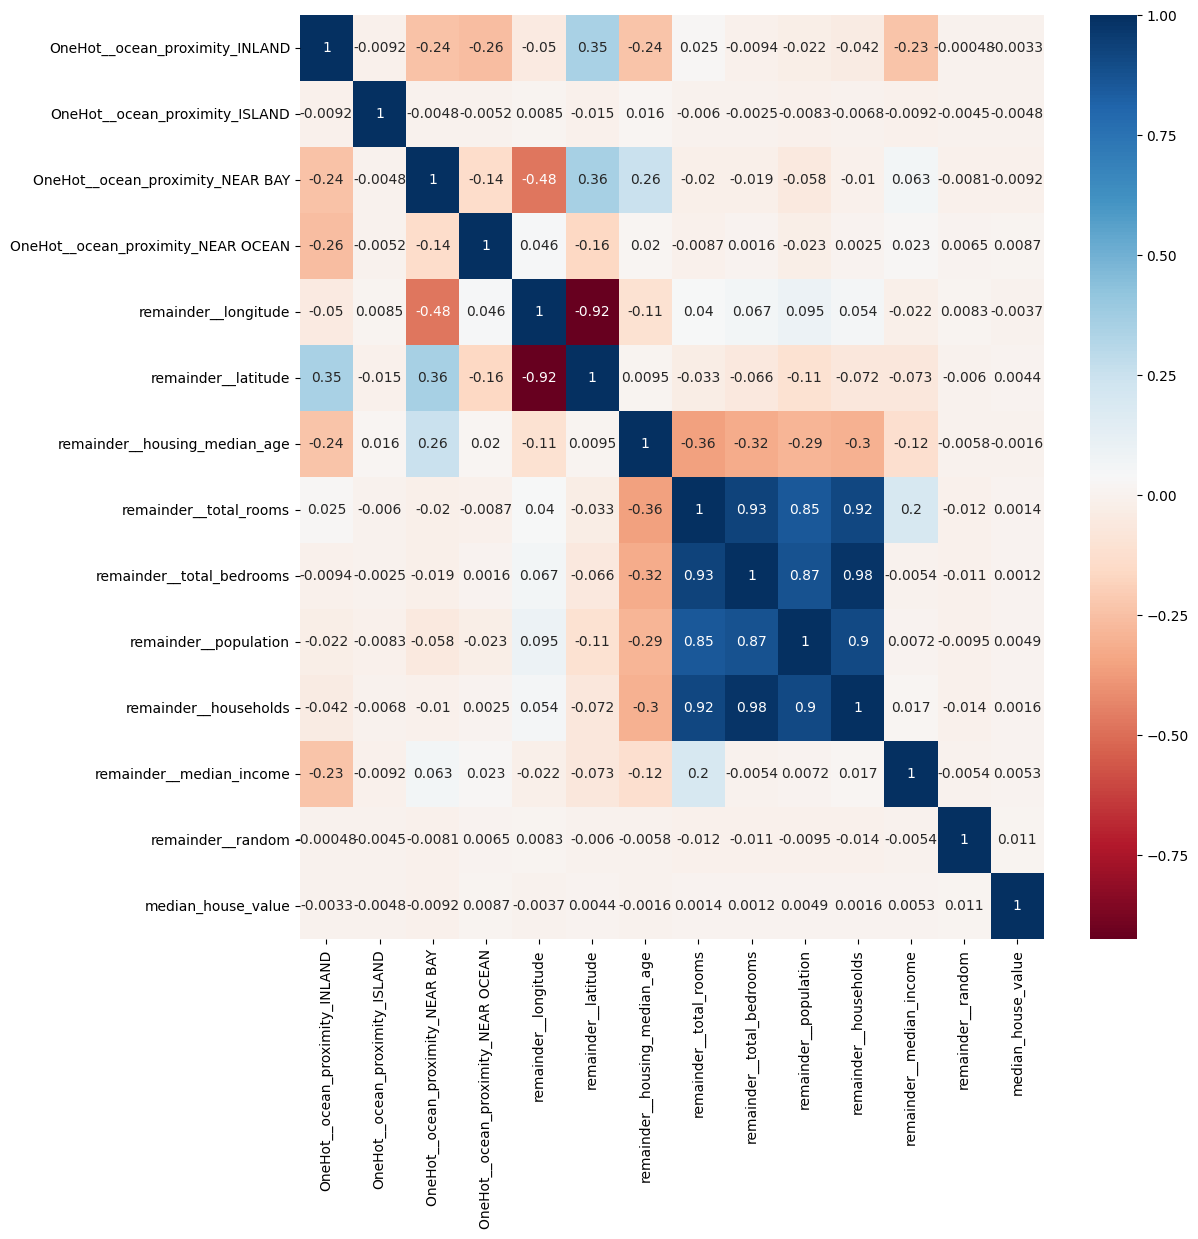

In [12]:
cor = pd.concat([X_train_hot, y_train], axis=1).corr()
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(cor, cmap="RdBu", annot=True)

## Cross-Validation (leave-one-out)

In [13]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=2)
for train_index, test_index in kf.split(X_train_hot):
  X_train_cv = X_train_hot.iloc[train_index]
  y_train_cv = y_train.iloc[train_index]
  X_val_cv = X_train_hot.iloc[test_index]
  y_val_cv = y_train.iloc[test_index]

In [16]:
for (train_index, test_index) in kf.split(X_train_hot):
  print(train_index, test_index)

[ 8173  8174  8175 ... 16343 16344 16345] [   0    1    2 ... 8170 8171 8172]
[   0    1    2 ... 8170 8171 8172] [ 8173  8174  8175 ... 16343 16344 16345]


In [17]:
from sklearn.linear_model import SGDRegressor, Lasso, Ridge, ARDRegression, ElasticNet, HuberRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression, r_regression, f_regression
from sklearn.pipeline import Pipeline, make_pipeline

## Trying Different Models
$$
MSE = \frac{1}{N}\sum_{i=1}^{N}\left(a(x^{(i)})-y^{(i)}\right)^2
$$
$$
MAE = \frac{1}{N}\sum_{i=1}^{N}\left|a(x^{(i)})-y^{(i)}\right|
$$
$$
Huber = \frac{1}{N}\sum_{i=1}^{N} \phi_{\varepsilon}\left(a(x^{(i)})-y^{(i)}\right),
$$
where
$$
\phi_{\varepsilon}(z) =\begin{cases}\dfrac{1}{2} z^2, & |z|<\varepsilon,\\
\varepsilon\left( |z|-\dfrac{1}{2}\varepsilon\right), & |z|\geq \varepsilon. \end{cases}
$$
$l_2$ regularization
$$
\|w\|_2^2 = \sum_{k=1}^{D} w_k^2
$$
$l_1$ regularization
$$
\|w\|_1 = \sum_{k=1}^{D} |w_k|
$$
Elastic
$$
a\|w\|_1 + \dfrac{1}{2}b\|w\|_2^2
$$

First model is using ridge regression after selecting 9 features with larger correlation

In [18]:
pipe1 = Pipeline([('select', SelectKBest(r_regression, k=9)), ('sc', StandardScaler()), ('reg', Ridge())])

We test it on the validation set

In [19]:
pipe1.fit(X_train_cv, y_train_cv)
pipe1.score(X_val_cv, y_val_cv)

0.5654958164416103

In [21]:
pipe1[0].get_feature_names_out()

array(['OneHot__ocean_proximity_ISLAND',
       'OneHot__ocean_proximity_NEAR BAY',
       'OneHot__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age', 'remainder__total_rooms',
       'remainder__total_bedrooms', 'remainder__households',
       'remainder__median_income', 'remainder__random'], dtype=object)

Second model is using ridge regression with all fetures

In [22]:
pipe2 = Pipeline([('sc', StandardScaler()), ('reg', Ridge())])
pipe2.fit(X_train_cv, y_train_cv)
pipe2.score(X_val_cv, y_val_cv)

0.643264747926402

By default, score is the Coefficient of Determination
$$
R^2 = 1-\frac{\sum\limits_{i=1}^{N}\left(a(x^{(i)})-y^{(i)}\right)^2}{\sum\limits_{i=1}^{N}\left(y^{(i)}-\bar{y}\right)^2}
$$

## Cross-Validation

In [23]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipe1, X_train_hot, y_train, cv=2) #KFold(2, shuffle=True)
print(scores, scores.mean())

[0.56306714 0.56549582] 0.5642814795997113


Correlation analyzis and cross-validation

In [27]:
corr_select = []
for r in range(1,X_train_hot.shape[1]+1):
  pipe1 = Pipeline([('sc', StandardScaler()), ('reg', Ridge())])
  corr_select.append(cross_val_score(pipe1, SelectKBest(r_regression, k=r).fit_transform(X_train_hot, y_train), y_train, cv=10).mean())

Text(0, 0.5, 'Score $R^2$')

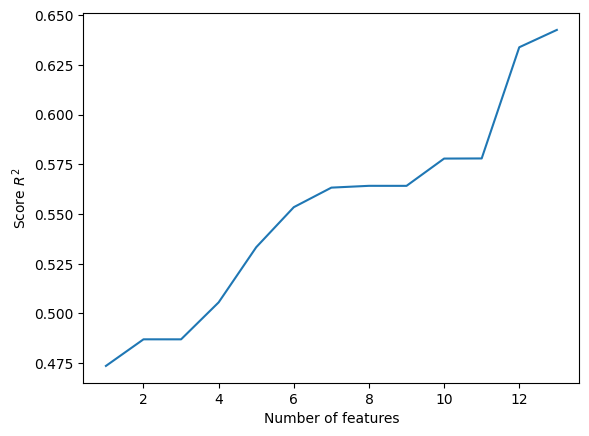

In [29]:
plt.plot(list(range(1, X_train_hot.shape[1]+1)), corr_select)
plt.xlabel('Number of features')
plt.ylabel('Score $R^2$')

## Mutual Information
$$
I(X;Y) = \sum_{y\in Y}\sum_{x\in X} p(x,y) \log\frac{p(x,y)}{p(x)p(y)}
$$

In [30]:
MI_select = []
for r in range(1, X_train_hot.shape[1]+1):
  pipe2 = Pipeline([('sc', StandardScaler()), ('reg', Ridge())])
  MI_select.append(cross_val_score(pipe2, SelectKBest(mutual_info_regression, k=r).fit_transform(X_train_hot, y_train), y_train, cv=10).mean())

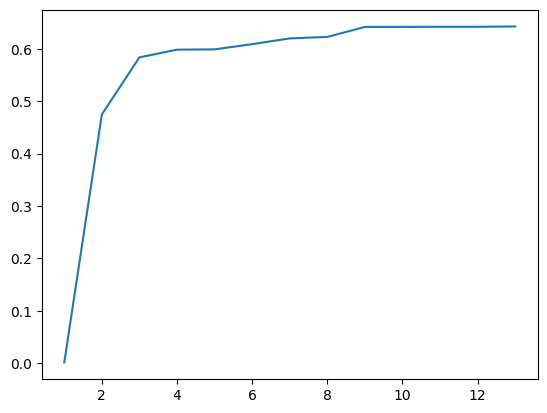

In [31]:
plt.plot(list(range(1, X_train_hot.shape[1]+1)), MI_select)

We can use the better number of the features selected by MI

In [32]:
selector_MI = SelectKBest(mutual_info_regression, k=9)
selector_MI.fit_transform(X_train_hot, y_train)
selector_MI.get_feature_names_out()

array(['OneHot__ocean_proximity_INLAND', 'remainder__longitude',
       'remainder__latitude', 'remainder__housing_median_age',
       'remainder__total_rooms', 'remainder__total_bedrooms',
       'remainder__population', 'remainder__households',
       'remainder__median_income'], dtype=object)

In [33]:
pipe2.fit(X_train_hot[selector_MI.get_feature_names_out()], y_train)

Pipeline(steps=[('sc', StandardScaler()), ('reg', Ridge())])

In [34]:
from sklearn.metrics import r2_score

In [35]:
r2_score(y_test, pipe2.predict(X_test_hot[selector_MI.get_feature_names_out()]))

0.6496833820195305

In [36]:
pipe2.fit(X_train_hot, y_train)
r2_score(y_test, pipe2.predict(X_test_hot))

0.6488295331475246

#Selection by Model:
1. train Lasso regression
2. Choose features by the weights
3. Train any model on these new features

In [41]:
pipe_Lasso = Pipeline([ ('sc', StandardScaler()), ('reg', Lasso())])

In [42]:
pipe_Lasso.fit(X_train_hot, y_train)

Pipeline(steps=[('sc', StandardScaler()), ('reg', Lasso())])

In [43]:
pd.DataFrame(abs(pipe_Lasso[-1].coef_), X_train_hot.columns).sort_values(0, ascending=False)

,0
remainder__median_income,74531.703948
remainder__latitude,54765.872112
remainder__longitude,54332.014124
remainder__total_bedrooms,43018.123660
remainder__population,41098.123979
OneHot__ocean_proximity_INLAND,18250.003732
remainder__households,16245.233459
remainder__total_rooms,13598.422629
remainder__housing_median_age,13593.150856
OneHot__ocean_proximity_ISLAND,2890.443154


## Recursive Feature Elimination

In [44]:
from sklearn.feature_selection import RFE

In [45]:
Rec_select = []
for r in range(1, X_train_hot.shape[1]):
  estimator = Lasso()
  scaler = StandardScaler()
  selector = RFE(estimator, n_features_to_select=r)
  selector.fit(scaler.fit_transform(X_train_hot), y_train)
  Rec_select.append(cross_val_score(estimator, scaler.fit_transform(X_train_hot[selector.get_feature_names_out(X_train_hot.columns.values)]), y_train, cv=10).mean())

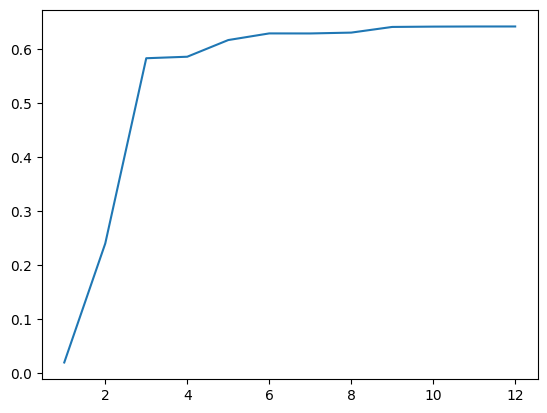

In [46]:
plt.plot(list(range(1, X_train_hot.shape[1])), Rec_select)

In [47]:
estimator = Lasso()
scaler = StandardScaler()
selector_Rec = RFE(estimator, n_features_to_select=9)
selector_Rec.fit(scaler.fit_transform(X_train_hot), y_train)
selector_Rec.get_feature_names_out(X_train_hot.columns.values)

array(['OneHot__ocean_proximity_INLAND', 'remainder__longitude',
       'remainder__latitude', 'remainder__housing_median_age',
       'remainder__total_rooms', 'remainder__total_bedrooms',
       'remainder__population', 'remainder__households',
       'remainder__median_income'], dtype=object)

## Creating New Features

In [48]:
#sns.pairplot(pd.concat([housing_hot, y_train], axis=1))

## Model Selection Via Grid Search

In [51]:
pipe3 = Pipeline([('select', SelectKBest()),('sc', StandardScaler()), ('reg', ElasticNet())])

In [52]:
pipe3.get_params()

{'memory': None,
 'steps': [('select', SelectKBest()),
  ('sc', StandardScaler()),
  ('reg', ElasticNet())],
 'transform_input': None,
 'verbose': False,
 'select': SelectKBest(),
 'sc': StandardScaler(),
 'reg': ElasticNet(),
 'select__k': 10,
 'select__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>,
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'reg__alpha': 1.0,
 'reg__copy_X': True,
 'reg__fit_intercept': True,
 'reg__l1_ratio': 0.5,
 'reg__max_iter': 1000,
 'reg__positive': False,
 'reg__precompute': False,
 'reg__random_state': None,
 'reg__selection': 'cyclic',
 'reg__tol': 0.0001,
 'reg__warm_start': False}

In [53]:
from sklearn.model_selection import GridSearchCV

In [54]:
param_grid = {'select__score_func': [mutual_info_regression, f_regression],
              'select__k': [8, 9],
              'reg__alpha': [0.1, 0.5],
              'reg__l1_ratio': [0, 0.5, 1]
              }

In [55]:
grid_search = GridSearchCV(pipe3, param_grid, cv=5)

In [56]:
grid_search.fit(X_train_hot, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.884e+13, tolerance: 1.749e+10 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.777e+13, tolerance: 1.749e+10 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('select', SelectKBest()),
                                       ('sc', StandardScaler()),
                                       ('reg', ElasticNet())]),
             param_grid={'reg__alpha': [0.1, 0.5], 'reg__l1_ratio': [0, 0.5, 1],
                         'select__k': [8, 9],
                         'select__score_func': [<function mutual_info_regression at 0x7ccee0ce6340>,
                                                <function f_regression at 0x7ccee109ce00>]})

In [57]:
grid_search.best_estimator_

Pipeline(steps=[('select',
                 SelectKBest(k=9,
                             score_func=<function mutual_info_regression at 0x7ccee0ce6340>)),
                ('sc', StandardScaler()),
                ('reg', ElasticNet(alpha=0.1, l1_ratio=1))])

In [58]:
grid_search.best_estimator_[:-1].get_feature_names_out()

array(['OneHot__ocean_proximity_INLAND', 'remainder__longitude',
       'remainder__latitude', 'remainder__housing_median_age',
       'remainder__total_rooms', 'remainder__total_bedrooms',
       'remainder__population', 'remainder__households',
       'remainder__median_income'], dtype=object)

# Final training and testing

In [59]:
best_model = SGDRegressor(alpha=0.001, penalty='elasticnet')
best_features = selector_MI.get_feature_names_out().tolist()

In [60]:
pipe = grid_search.best_estimator_ # Pipeline([('scaler', StandardScaler()), ('model', best_model)])

In [61]:
pipe.fit(X_train_hot,y_train)

Pipeline(steps=[('select',
                 SelectKBest(k=9,
                             score_func=<function mutual_info_regression at 0x7ccee0ce6340>)),
                ('sc', StandardScaler()),
                ('reg', ElasticNet(alpha=0.1, l1_ratio=1))])

In [ ]:
#X_test_hot = pd.DataFrame(transform.fit_transform(X_test), columns=transform.get_feature_names_out())

Predict for all test records

In [63]:
y_predict = pipe.predict(X_test_hot)

In [65]:
pipe.score(X_test_hot, y_test)

0.6496858810253816

In [64]:
y_predict[0]

200078.65559198853

Choose one record from the DataFrame (use doble brackets)

In [66]:
X_test.iloc[[0]]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,random
14416,-117.24,32.79,20.0,961.0,278.0,525.0,254.0,3.1838,NEAR OCEAN,1


Transform it if needed

In [67]:
X_test_hot[grid_search.best_estimator_[:-1].get_feature_names_out()].iloc[[0]]

,OneHot__ocean_proximity_INLAND,remainder__longitude,remainder__latitude,remainder__housing_median_age,remainder__total_rooms,remainder__total_bedrooms,remainder__population,remainder__households,remainder__median_income
0,0.0,-117.24,32.79,20.0,961.0,278.0,525.0,254.0,3.1838


Make a prediction for this record

In [69]:
pipe.predict(X_test_hot.iloc[[0]]), y_test.iloc[0]

(array([200078.65559199]), 245800.0)

You could do it by using weights $w_i$

$$
a(x) = w_0 + w_1 x_1+\ldots + w_d x_d = w^T \tilde{x},
$$
where
$$
\tilde{x} = (1,\ x_1,\ x_2, \ldots,\ x_d)^T
$$

In [70]:
pipe[-1].coef_

array([-17783.42038367, -54561.94267257, -56086.33382456,  13199.66901758,
       -13506.71657373,  43141.34637119, -41101.44651747,  15877.41669265,
        74357.21813641])

In [71]:
pipe[-1].intercept_

206644.400097883

In [72]:
pipe[1].transform(X_test_hot[grid_search.best_estimator_[:-1].get_feature_names_out()].iloc[[0]]).dot(pipe[-1].coef_) + pipe[-1].intercept_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


array([200078.65559199])

#Summary
* ## Split Train/Validation/Test
* ## or Train/Test and use cross-validation
* ## Feature selection (by correlation/MI or by model)
* ## and probably new features
* ## Regression model selection + its parameters by grid-search
* ## Calculate chosen metric (MSE, RMSE, MAE, MAPE, or $R^2$) on the Test set
